# Imports

In [1]:
from extract_center import CenterExtracter
from run import Run
from misc_tools import Plotter, Smoother
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Defining the Data Directory and Result Directory

In [2]:
sequence = "ref"
DATA_DIR = '../../data/extracted_images/' + sequence
RESULT_DIR = '../../data/results/' + sequence

# Initializing the Classes

In [3]:
run = Run(DATA_DIR, RESULT_DIR)
ce = CenterExtracter()

# Extracting Information

## Determining the *Region of Interest*

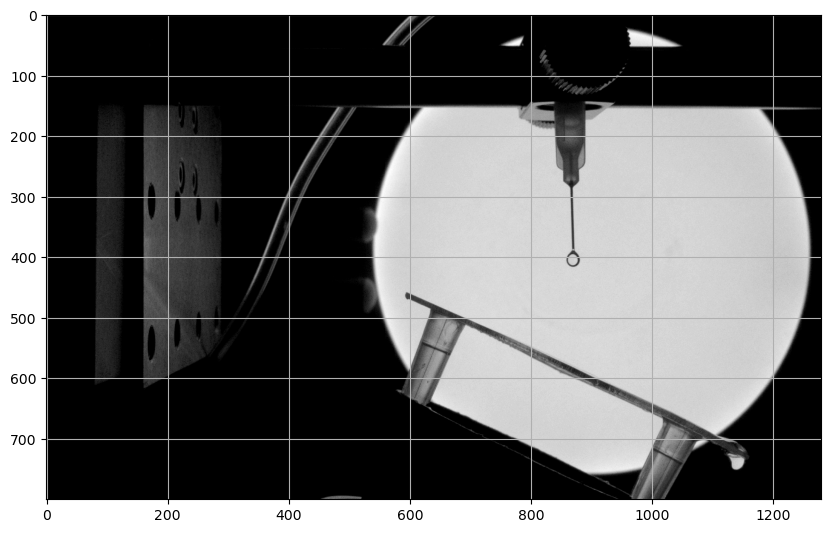

In [4]:
images = run.get_images()
img_1 = ce._read_image(images[0])
ce._show_image(img_1)

In [5]:
region_of_interset = (700, 350, 1200, 700)

## Reiniatilizing the Classes

In [6]:
run = Run(DATA_DIR, RESULT_DIR, region = region_of_interset)

## Setting the Reference Image

In [7]:
run._set_ref_image(-10)

## Extracting Information

In [8]:
df = run.all_points(crop_included=True, binary=True, verbose=False, num_images=None, raise_error=False)

Getting list of images...
Extracting data from images...


Extracting data from images: 100%|██████████| 171/171 [00:18<00:00,  9.49it/s]


Saving to csv...
Done!


## Some Preliminary Analysis

### None Values

In [9]:
df.isna().sum()

id        0
x        15
y        15
r1       15
r2       15
theta    15
dtype: int64

In [10]:
# df = pd.read_csv(RESULT_DIR + '/centers_using_ap.csv')

### Sample Images

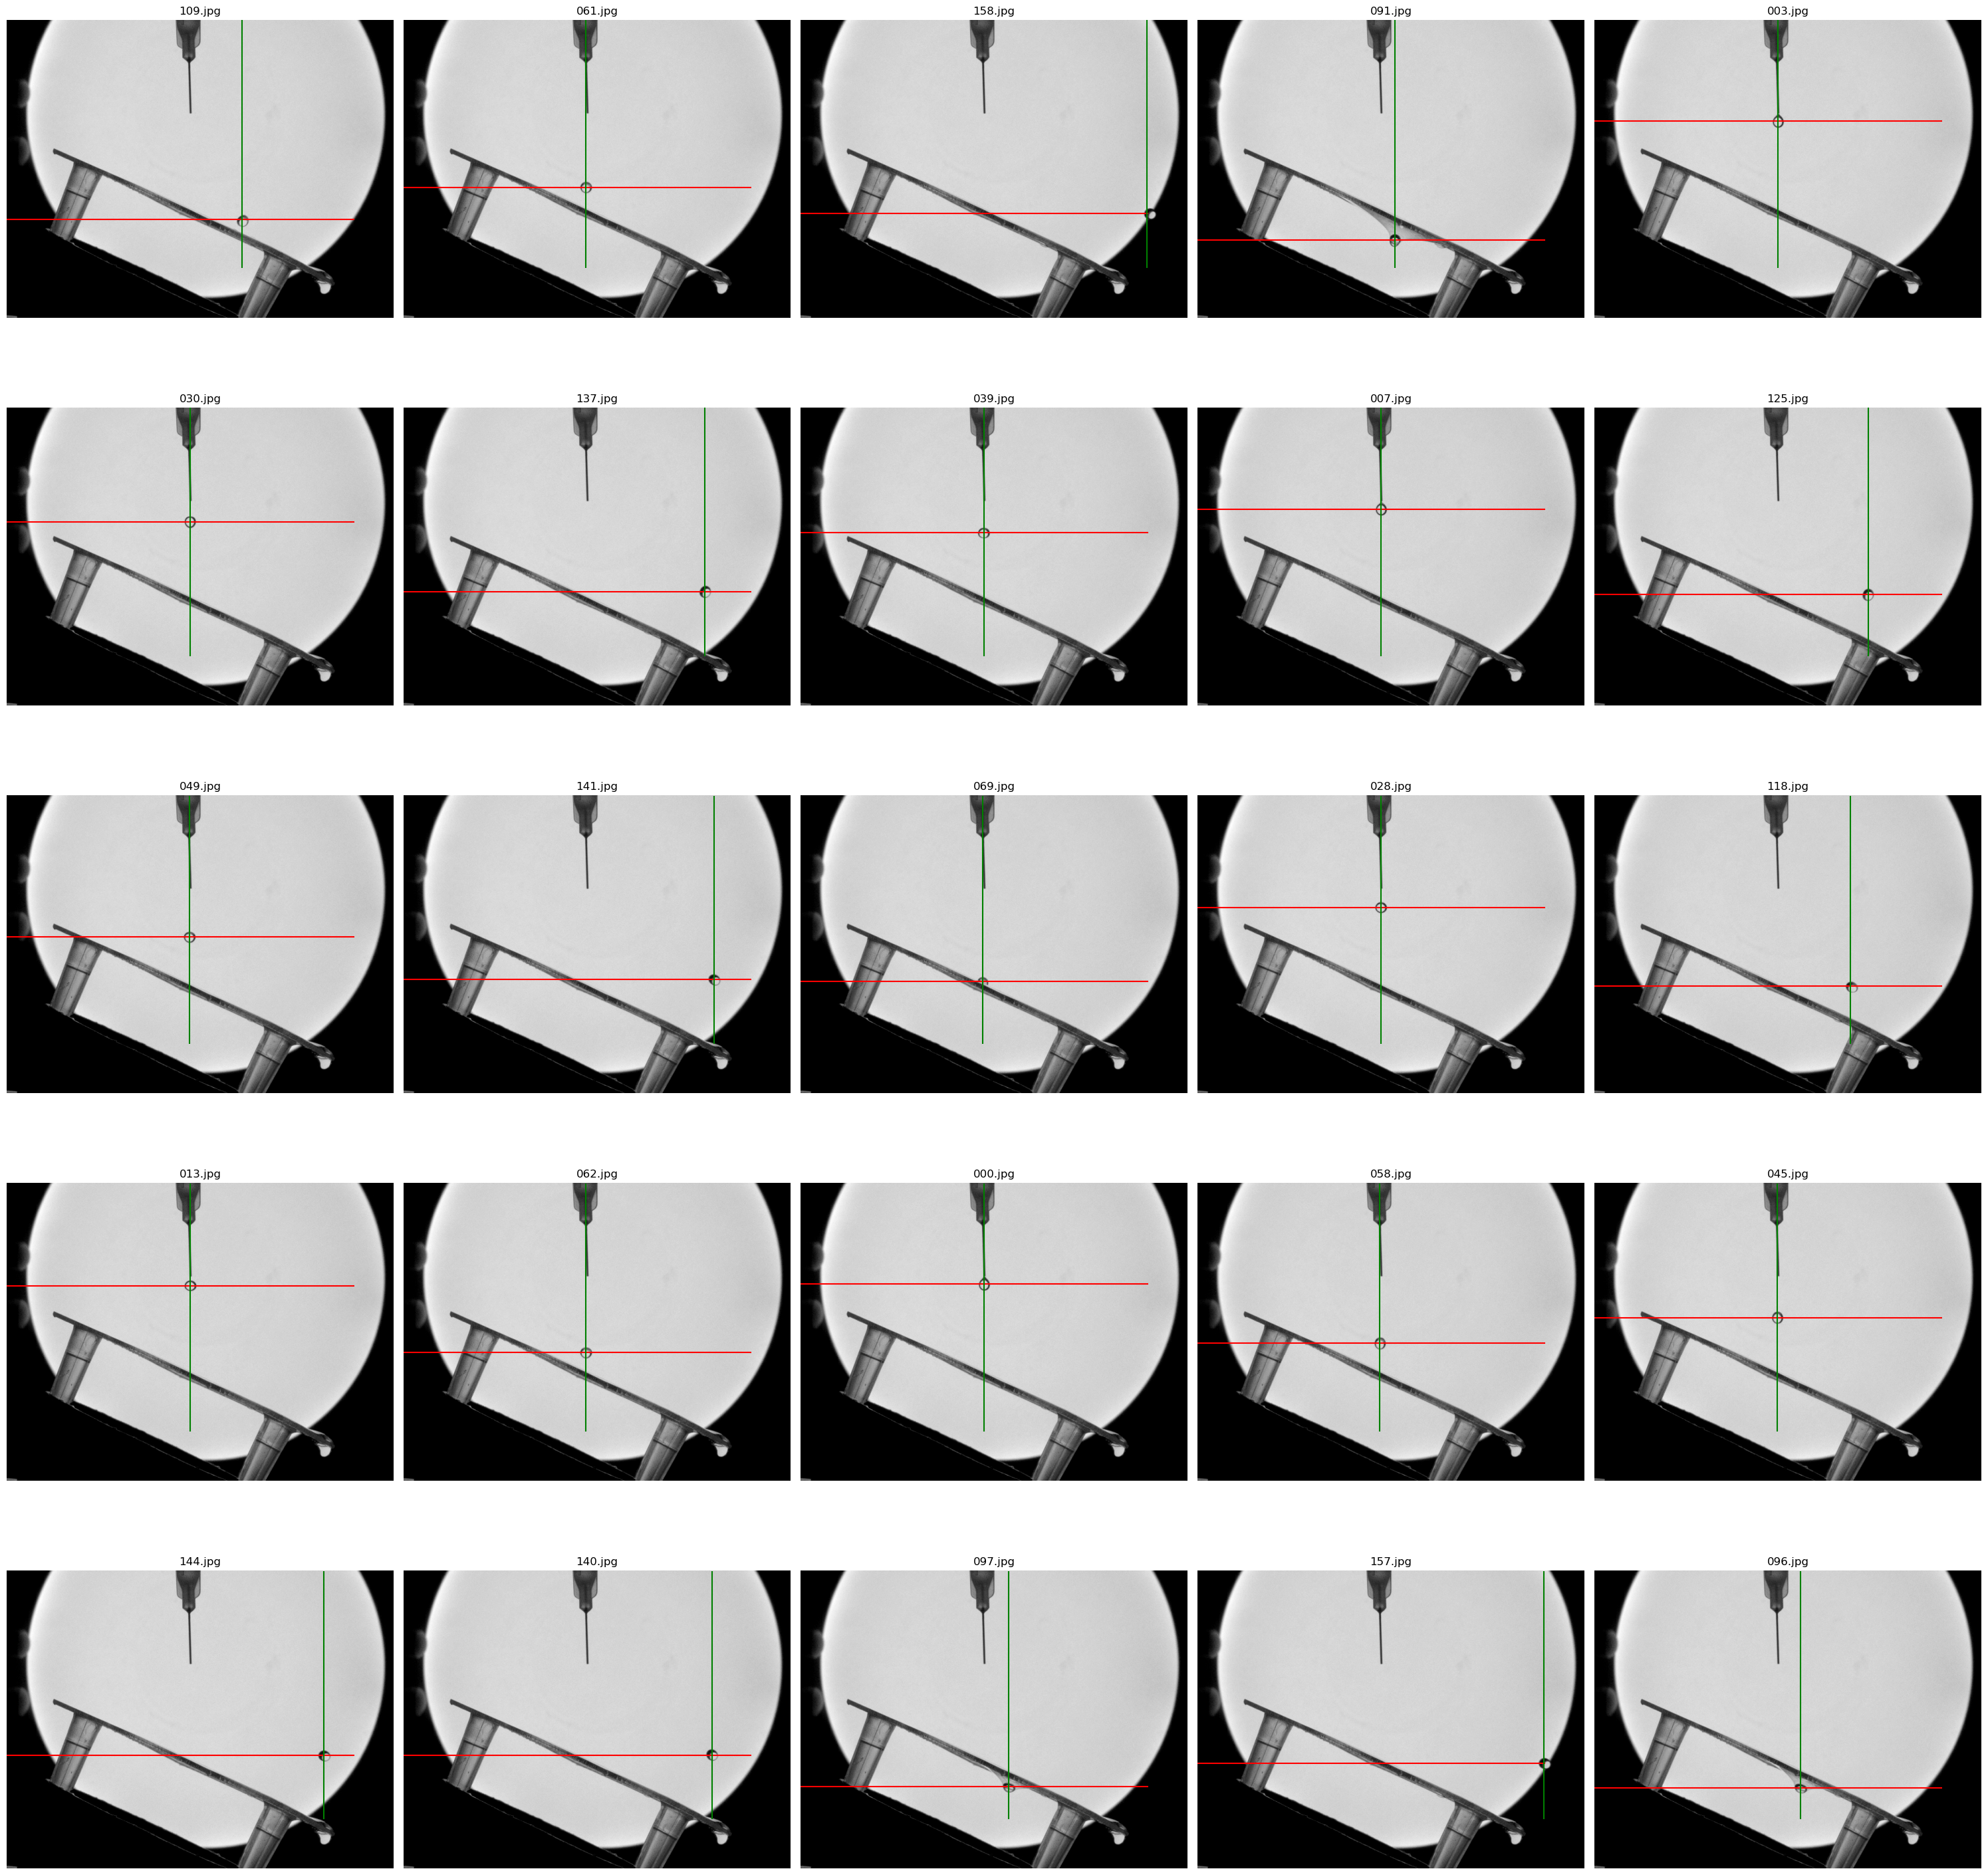

In [11]:
p = Plotter(df, RESULT_DIR)
p.get_samples(25, file_name = f"{sequence}_samples.png")

## Extracting Objectives

### Getting Frame Information

In [12]:
info_dict = {
    "first_frame": 1,
    "last_frame": 2,
    "contact_frame": 3,
    "leave_frame": 4,
    "angle": 5,
}

In [13]:
def update_info(file, info, line_num = 4):
    with open(file, "r") as f:
        texts = f.readlines()
    line = texts[line_num]
    line = line.split(":")[0] + ": " + info + "\n"
    texts[line_num] = line
    with open(file, "w") as f:
        f.writelines(texts)
    return texts[line_num]

leave_frame = df[df["y"] == df["y"].max()]["id"].values[-1].split("/")[-1]
last_frame = df.iloc[-10]["id"].split("/")[-1]
update_info(f"{DATA_DIR}.txt", leave_frame, line_num = 4)
update_info(f"{DATA_DIR}.txt", last_frame, line_num = 2)

In [14]:
def get_info(file):
    information = {}
    with open(file, "r") as f:
        texts = f.readlines()
    for key, value in info_dict.items():
        line = texts[value]
        info = line.split(":")[1].strip()
        information[key] = info
    return information

information = get_info(f"{DATA_DIR}.txt")

In [15]:
first_frame = DATA_DIR + "/" +information["first_frame"]
last_frame = DATA_DIR + "/" +information["last_frame"]
contact_frame = DATA_DIR + "/" +information["contact_frame"]
angle = information["angle"]
leave_frame = DATA_DIR + "/" +information["leave_frame"]

In [16]:
first_frame, last_frame

('../../data/extracted_images/ref/017.jpg',
 '../../data/extracted_images/ref/161.jpg')

In [18]:
s = Smoother(df)
df_s = s.smoothen(remove_noise = False)

c:\Users\harik\Desktop\mini-project\codes\extraction\misc_tools.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["r"] = ((df["r1"] + df["r2"]) / 2).astype(int)
c:\Users\harik\Desktop\mini-project\codes\extraction\misc_tools.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = self.savitzky_golay(col_value, window_size=w, order=order)


### Getting Angle and Velocity

In [57]:
df_s["vx"] = df_s["x"].diff(7)/7
df_s["vy"] = df_s["y"].diff(7)/7

df_s.dropna(inplace=True)
df_s["v"] = np.sqrt(df_s["vx"]**2 + df_s["vy"]**2)

C:\Users\harik\AppData\Local\Temp\ipykernel_21292\3680160857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["vx"] = df_s["x"].diff(7)/7
C:\Users\harik\AppData\Local\Temp\ipykernel_21292\3680160857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["vy"] = df_s["y"].diff(7)/7
C:\Users\harik\AppData\Local\Temp\ipykernel_21292\3680160857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

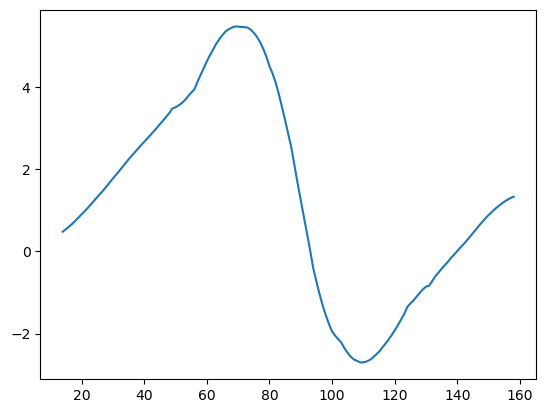

In [58]:
plt.plot(df_s["vy"])

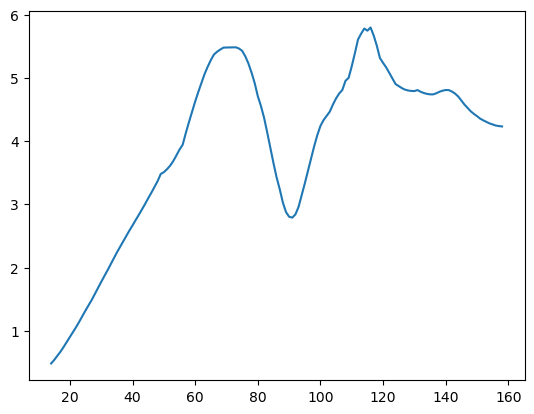

In [59]:
plt.plot(df_s["v"])

In [60]:
def get_angle(row):
    vx = row["vx"]
    vy = -row["vy"]
    if vx == 0 and vy == 0:
        return 0
    elif vx==0:
        return 90
    else:
        return np.arctan(vy/vx)*180/np.pi

In [61]:
df_s["angle"] = df_s.apply(get_angle, axis=1)

C:\Users\harik\AppData\Local\Temp\ipykernel_21292\1865048196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["angle"] = df_s.apply(get_angle, axis=1)


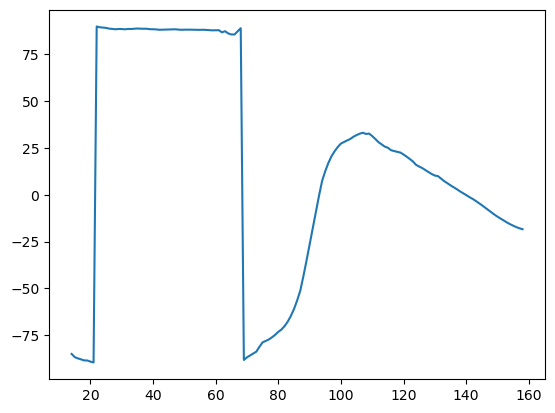

In [62]:
plt.plot(df_s["angle"])

In [66]:
df_s[df_s["id"] == contact_frame].T

68
id     ../../data/extracted_images/ref/068.jpg
x                                   865.517678
y                                   576.107204
r1                                    8.184345
r2                                    9.613348
theta                                 1.103906
r                                     8.663452
vx                                   -0.094914
vy                                    5.451908
angle                                89.002621
v                                     5.452734

In [68]:
df_s[df_s["id"] == leave_frame].T

90
id     ../../data/extracted_images/ref/090.jpg
x                                    900.87162
y                                   642.797126
r1                                   13.078843
r2                                   13.004727
theta                                 1.306695
r                                    12.838722
vx                                     2.51206
vy                                    1.250412
angle                               -26.462448
v                                     2.806061

In [71]:
reg = re.compile(r"\d+")
contact_frame_num = int(reg.findall(contact_frame)[0])
leave_frame_num = int(reg.findall(leave_frame)[0])
contact_frame_num, leave_frame_num

(68, 90)

In [74]:
angle_at_contact_frame = df_s.loc[contact_frame_num]["angle"]
angle_at_leave_frame = df_s.loc[leave_frame_num]["angle"]
angle_at_contact_frame, angle_at_leave_frame

(89.00262065046834, -26.462447588650484)

In [77]:
velocity_at_leave_frame = df_s.loc[leave_frame_num]["v"]
velocity_at_contact_frame = df_s.loc[contact_frame_num]["v"]
velocity_at_leave_frame, velocity_at_contact_frame

(2.8060605364262443, 5.452734404125173)

In [86]:
x_velocity_at_leave_frame = df_s.loc[leave_frame_num]["vx"]
x_velocity_at_contact_frame = df_s.loc[contact_frame_num]["vx"]

y_velocity_at_leave_frame = df_s.loc[leave_frame_num]["vy"]
y_velocity_at_contact_frame = df_s.loc[contact_frame_num]["vy"]

### Adding Information

In [101]:
pattern = "***"
information = f"""\n{pattern*20}
AT CONTACT FRAME:
### ANGLE: {angle_at_contact_frame}
### VELOCITY: {velocity_at_contact_frame}
### X VELOCITY: {x_velocity_at_contact_frame}
### Y VELOCITY: {y_velocity_at_contact_frame}

AT LEAVE FRAME:
### ANGLE: {angle_at_leave_frame}
### VELOCITY: {velocity_at_leave_frame}
### X VELOCITY: {x_velocity_at_leave_frame}
### Y VELOCITY: {y_velocity_at_leave_frame}
{pattern*20}"""
print(information)


************************************************************
AT CONTACT FRAME:
### ANGLE: 89.00262065046834
### VELOCITY: 5.452734404125173
### X VELOCITY: -0.09491397239552109
### Y VELOCITY: 5.451908273235566

AT LEAVE FRAME:
### ANGLE: -26.462447588650484
### VELOCITY: 2.8060605364262443
### X VELOCITY: 2.512060070766828
### Y VELOCITY: 1.2504119061124226
************************************************************


First, remove anything between the asterisks.

In [111]:
with open(DATA_DIR+".txt", "r") as f:
    texts = f.readlines()
text = "".join(texts[:6])
print(text)
all_text = text+information

### ref.tif
### First Frame ID: 017.jpg
### Last Frame ID: 161.jpg
### Contact Frame ID: 068.jpg
### Leave Frame ID: 090.jpg
### Angle: 24.5



In [119]:
with open(RESULT_DIR +"/info.txt", "w") as f:
    f.writelines(all_text)

### Save the DataFrame

In [116]:
df_s.to_csv(RESULT_DIR + f"/{sequence}_smoothened.csv", index=False)